
## Install all the package of detectron2
Subir tigre, frame y vid

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15280, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 15280 (delta 0), reused 3 (delta 0), pack-reused 15275
Receiving objects: 100% (15280/15280), 6.17 MiB | 7.48 MiB/s, done.
Resolving deltas: 100% (11115/11115), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparin

## Print model version

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.1 ; cuda:  cu118
detectron2: 0.6


## import the model and utilities

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Read sample image to test

In [ ]:
#!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./tiger1.jpg")
cv2_imshow(im)

Output hidden; open in https://colab.research.google.com to view.

## Create model configuration importing Segmentation model to test

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[11/21 05:32:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:01, 105MB/s]                           
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Print outputs

In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([23], device='cuda:0')
Boxes(tensor([[ 238.7525,  192.5820, 2589.1948, 2002.9091]], device='cuda:0'))


In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

# Fine tuning process with our dataset

### Download adapted dataset from Roboflow in Yolov8 format
https://universe.roboflow.com/xyz-mithp/big-cats/dataset/1

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="RlA7Euq7pOskuk4UMQKf")
project = rf.workspace("xyz-mithp").project("big-cats")
dataset = project.version(1).download("coco")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 994.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstalled opencv-python-headless-4.8.1.78
  Attempting uninstall: idna
    Found existin

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to BIG-CATS-1 in coco:: 100%|██████████| 3602/3602 [00:00<00:00, 4544.10it/s]


### Declare paths from downloaded models

In [ ]:
from detectron2.data.datasets import register_coco_instances

# Define dataset paths
train_json = "/content/BIG-CATS-1/train/_annotations.coco.json"
val_json = "/content/BIG-CATS-1/valid/_annotations.coco.json"
train_images_dir = "/content/BIG-CATS-1/train"
val_images_dir = "/content/BIG-CATS-1/valid"
test_json = "/content/BIG-CATS-1/test/_annotations.coco.json"
test_images_dir = "/content/BIG-CATS-1/test"

# Register the datasets
register_coco_instances("big_cats_train", {}, train_json, train_images_dir)
register_coco_instances("big_cats_val", {}, val_json, val_images_dir)
register_coco_instances("big_cats_test", {}, test_json, test_images_dir)

### Set classes for training

In [ ]:
big_cats_metadata = MetadataCatalog.get("big_cats_train").set(thing_classes=["cheetah-tiger-jaguar", "Cheetah", "Jaguar", "Tiger"])

### Obtain 3 random images from the dataset to see it's fine

WARNING [11/21 05:36:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/21 05:36:13 d2.data.datasets.coco]: Loaded 3144 images in COCO format from /content/BIG-CATS-1/train/_annotations.coco.json


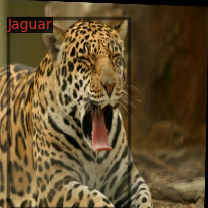

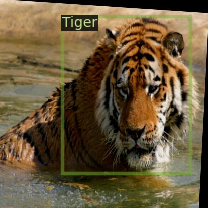

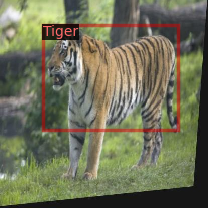

In [ ]:
dataset_dicts = DatasetCatalog.get("big_cats_train")

# Visualize random samples
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=big_cats_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

### Train the model with configuration and classes

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog
import os

# Set the metadata with your classes
big_cats_metadata = MetadataCatalog.get("big_cats_train").set(thing_classes=["cheetah-tiger-jaguar", "Cheetah", "Jaguar", "Tiger"])

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

# Update dataset names for your dataset
cfg.DATASETS.TRAIN = ("big_cats_train",)
cfg.DATASETS.TEST = ("big_cats_test",)  # Update if you have a test set

# Other configurations
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300  # Adjust as necessary
cfg.SOLVER.STEPS = []  # Learning rate schedule

# Obtain the number of classes from metadata
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(big_cats_metadata.thing_classes)  # Automatically set the number of classes

# Output directory for training artifacts
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Set up the trainer and start training
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[11/21 05:36:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  roi_heads.mask_head.mask_fcn1.{bias, weight}
  roi_heads.mask_head.mask_fcn2.{bias, weight}
  roi_heads.mask_head.mask_fcn3.{bias, weight}
  roi_heads.mask_head.mask_fcn4.{bias, weight}
  roi_heads.mask_head.deconv.{bias, weight}
  roi_heads.mask_head.predictor.{bias, weight}


[11/21 05:36:59 d2.engine.train_loop]: Starting training from iteration 0
[11/21 05:37:09 d2.utils.events]:  eta: 0:01:36  iter: 19  total_loss: 2.059  loss_cls: 1.441  loss_box_reg: 0.6043  loss_rpn_cls: 0.0009676  loss_rpn_loc: 0.007412    time: 0.3353  last_time: 0.3086  data_time: 0.0228  last_data_time: 0.0071   lr: 1.6068e-05  max_mem: 1915M
[11/21 05:37:20 d2.utils.events]:  eta: 0:01:24  iter: 39  total_loss: 1.677  loss_cls: 1.047  loss_box_reg: 0.6124  loss_rpn_cls: 0.001102  loss_rpn_loc: 0.005727    time: 0.3824  last_time: 0.3062  data_time: 0.0161  last_data_time: 0.0057   lr: 3.2718e-05  max_mem: 1915M
[11/21 05:37:26 d2.utils.events]:  eta: 0:01:17  iter: 59  total_loss: 1.193  loss_cls: 0.5715  loss_box_reg: 0.6169  loss_rpn_cls: 0.0007847  loss_rpn_loc: 0.006438    time: 0.3581  last_time: 0.3495  data_time: 0.0083  last_data_time: 0.0074   lr: 4.9367e-05  max_mem: 1915M
[11/21 05:37:33 d2.utils.events]:  eta: 0:01:10  iter: 79  total_loss: 1.017  loss_cls: 0.4349  lo

### THe new model now finetuned is saved

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[11/21 05:39:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


### Declare predictor, be used later

WARNING [11/21 05:40:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/21 05:40:32 d2.data.datasets.coco]: Loaded 151 images in COCO format from /content/BIG-CATS-1/test/_annotations.coco.json
[11/21 05:40:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


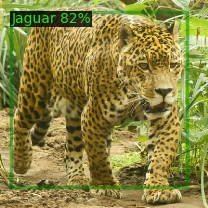

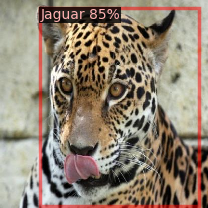

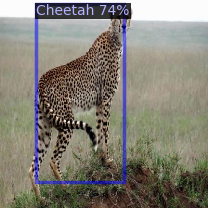

In [ ]:
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog
import random
import cv2
from google.colab.patches import cv2_imshow
from detectron2.engine import DefaultPredictor

# Load the test dataset
dataset_dicts = DatasetCatalog.get("big_cats_test")
big_cats_metadata = MetadataCatalog.get("big_cats_train")

# Initialize the predictor
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Update path to the model weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for object detection
predictor = DefaultPredictor(cfg)

# Visualize random samples from the test set
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=big_cats_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE  # Use IMAGE mode for object detection
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])


Run evaluation

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Assuming cfg is already set up with your test dataset
evaluator = COCOEvaluator("big_cats_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "big_cats_val")

# Run evaluation
inference_on_dataset(trainer.model, val_loader, evaluator)


[11/21 05:40:52 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [11/21 05:40:52 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [11/21 05:40:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/21 05:40:52 d2.data.datasets.coco]: Loaded 299 images in COCO format from /content/BIG-CATS-1/valid/_annotations.coco.json
[11/21 05:40:52 d2.data.build]: Distribution of instances among all 4 categories:
|   category    | #instances   |  category  | #instances   |  category  | #instances   |
|:-------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| cheetah-tig.. | 0            |  Cheetah   | 97           |   Jaguar   | 111          |
|     Tiger     | 95           |            |              |            |              |
|     total   

OrderedDict([('bbox',
              {'AP': 42.18205896266961,
               'AP50': 85.0367662344362,
               'AP75': 35.484360875057476,
               'APs': nan,
               'APm': nan,
               'APl': 42.18301767290554,
               'AP-cheetah-tiger-jaguar': nan,
               'AP-Cheetah': 35.221504173439264,
               'AP-Jaguar': 46.47146103230623,
               'AP-Tiger': 44.853211682263314})])

## Now test on video
Start by obtaining frames per video

In [ ]:
import cv2
import os

def extraer_fotogramas(video_path, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_file = os.path.join(output_dir, f"frame_{frame_count}.jpg")
        cv2.imwrite(frame_file, frame)
        frame_count += 1

    cap.release()
    print(f"Total de fotogramas extraídos: {frame_count}")

# Uso del script
video_path = "./vid.mp4"  # Ruta del video
extracted_frames = "./video_frames"  # Ruta de la carpeta de salida
extraer_fotogramas(video_path, extracted_frames)


Total de fotogramas extraídos: 254


##Predecimos para cada frame obtenido

In [ ]:
import json
import glob

# ... Resto del código ...

def realizar_prediccion(image):
    outputs = predictor(image)
    v = Visualizer(image[:, :, ::-1], metadata=big_cats_metadata, scale=0.5, instance_mode=ColorMode.IMAGE)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    detalles_predicciones = []  # Para guardar detalles de las predicciones

    instances = outputs["instances"].to("cpu")
    if instances.has("pred_boxes"):
        pred_classes = instances.pred_classes.tolist()
        scores = instances.scores.tolist()
        pred_boxes = instances.pred_boxes.tensor.tolist()

        for clase_id, score, bbox in zip(pred_classes, scores, pred_boxes):
            clase = big_cats_metadata.thing_classes[clase_id]
            detalles_predicciones.append({
                "clase": clase,
                "score": score,
                "bbox": bbox
            })

    imagen_procesada = out.get_image()[:, :, ::-1]
    return imagen_procesada, detalles_predicciones

# Modificación en procesar_fotogramas para guardar detalles de las predicciones
def procesar_fotogramas(frames_dir, output_dir):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    todas_las_predicciones = []  # Para almacenar todas las predicciones de todos los fotogramas

    for frame_path in glob.glob(os.path.join(frames_dir, '*.jpg')):
        frame = cv2.imread(frame_path)
        predicted_image, detalles_predicciones = realizar_prediccion(frame)
        output_path = os.path.join(output_dir, os.path.basename(frame_path))
        cv2.imwrite(output_path, predicted_image)

        # Añadir detalles de las predicciones con el nombre del fotograma
        todas_las_predicciones.append({
            "fotograma": os.path.basename(frame_path),
            "predicciones": detalles_predicciones
        })

    # Guardar todas las predicciones en un archivo JSON
    with open('detalles_predicciones_detectron2.json', 'w') as f:
        json.dump(todas_las_predicciones, f)

    print("Proceso de detección completado.")

# Llamada a la función para procesar los fotogramas
processed_frames = "./processed_frames"

procesar_fotogramas(extracted_frames, processed_frames)


Proceso de detección completado.


## Rearmando frames, creador de video

In [ ]:
#CREADOR DE VÍDEOS, REARMAR FRAMES

import cv2
import os
import glob

def crear_video(input_dir, output_video_path, fps):
    images = [cv2.imread(file) for file in sorted(glob.glob(os.path.join(input_dir, '*.jpg')))]
    height, width, layers = images[0].shape
    size = (width, height)

    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

    for img in images:
        out.write(img)
    out.release()

# Uso del script
 # Directorio con las imágenes
output_video_path = './output2.mp4'  # Ruta del video de salida
fps = 24  # FPS (fotogramas por segundo) del video
crear_video(processed_frames, output_video_path, fps)


OBtain json to compare

In [ ]:
import json

# Ruta al archivo JSON
archivo_json = 'detalles_predicciones_detectron2.json'

# Cargar el archivo JSON
with open(archivo_json, 'r') as file:
    resultados = json.load(file)

# Imprimir el contenido del archivo JSON
for resultado in resultados:
    print(f"Fotograma: {resultado['fotograma']}")
    for prediccion in resultado['predicciones']:
        clase = prediccion['clase']
        score = prediccion['score']
        bbox = prediccion['bbox']
        print(f"  Clase: {clase}, Score: {score}, BBox: {bbox}")
    print("\n")  # Imprime una línea en blanco entre fotogramas para mejor legibilidad


Fotograma: frame_221.jpg
  Clase: Cheetah, Score: 0.858181893825531, BBox: [534.4876098632812, 482.43280029296875, 1441.0997314453125, 982.3179321289062]


Fotograma: frame_117.jpg
  Clase: Cheetah, Score: 0.8663040995597839, BBox: [426.39300537109375, 491.1280822753906, 1408.4942626953125, 958.5442504882812]


Fotograma: frame_70.jpg
  Clase: Cheetah, Score: 0.7966145873069763, BBox: [73.69142150878906, 446.2125549316406, 1209.12255859375, 924.1700439453125]
  Clase: Cheetah, Score: 0.5148947834968567, BBox: [502.2521667480469, 355.84600830078125, 1294.299560546875, 995.0947265625]
  Clase: Cheetah, Score: 0.5016974210739136, BBox: [206.2073211669922, 170.2637481689453, 1335.9444580078125, 1071.975341796875]


Fotograma: frame_180.jpg
  Clase: Cheetah, Score: 0.871887743473053, BBox: [486.25445556640625, 493.337158203125, 1466.1866455078125, 975.2205200195312]


Fotograma: frame_58.jpg
  Clase: Cheetah, Score: 0.8209342360496521, BBox: [275.20538330078125, 430.6369323730469, 1214.1916

### Obtain json to compare with yolo

In [ ]:
import json

# Ruta al archivo JSON
archivo_json = 'detalles_predicciones_detectron2.json'

# Definir la clase para sumar los puntajes
clase_objetivo = 'Cheetah'  # Cambia esto a la clase que deseas sumar

# Cargar el archivo JSON
with open(archivo_json, 'r') as file:
    resultados = json.load(file)

# Inicializar la suma de scores para la clase específica
suma_scores_clase_objetivo = 0

# Imprimir el contenido del archivo JSON y calcular la suma de scores para la clase objetivo
for resultado in resultados:
    print(f"Fotograma: {resultado['fotograma']}")
    for prediccion in resultado['predicciones']:
        clase = prediccion['clase']
        score = prediccion['score']
        bbox = prediccion['bbox']
        print(f"  Clase: {clase}, Score: {score}, BBox: {bbox}")

        # Sumar el score si la clase coincide con la clase objetivo
        if clase.lower() == clase_objetivo.lower():
            suma_scores_clase_objetivo += score

    print("\n")  # Imprime una línea en blanco entre fotogramas para mejor legibilidad

# Imprimir la suma total de scores para la clase objetivo
print(f"Suma total de scores para '{clase_objetivo}': {suma_scores_clase_objetivo}")


Fotograma: frame_221.jpg
  Clase: Cheetah, Score: 0.858181893825531, BBox: [534.4876098632812, 482.43280029296875, 1441.0997314453125, 982.3179321289062]


Fotograma: frame_117.jpg
  Clase: Cheetah, Score: 0.8663040995597839, BBox: [426.39300537109375, 491.1280822753906, 1408.4942626953125, 958.5442504882812]


Fotograma: frame_70.jpg
  Clase: Cheetah, Score: 0.7966145873069763, BBox: [73.69142150878906, 446.2125549316406, 1209.12255859375, 924.1700439453125]
  Clase: Cheetah, Score: 0.5148947834968567, BBox: [502.2521667480469, 355.84600830078125, 1294.299560546875, 995.0947265625]
  Clase: Cheetah, Score: 0.5016974210739136, BBox: [206.2073211669922, 170.2637481689453, 1335.9444580078125, 1071.975341796875]


Fotograma: frame_180.jpg
  Clase: Cheetah, Score: 0.871887743473053, BBox: [486.25445556640625, 493.337158203125, 1466.1866455078125, 975.2205200195312]


Fotograma: frame_58.jpg
  Clase: Cheetah, Score: 0.8209342360496521, BBox: [275.20538330078125, 430.6369323730469, 1214.1916